In [1]:
import os
import ray

In [2]:
import sys; sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv()
%load_ext autoreload
%autoreload 2

In [3]:
# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
ray.init()

2024-07-23 13:05:17,170	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.14
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [4]:
ray.cluster_resources()

{'node:127.0.0.1': 1.0,
 'memory': 428568576.0,
 'object_store_memory': 214284288.0,
 'node:__internal_head__': 1.0,
 'GPU': 1.0,
 'CPU': 8.0}

In [5]:
# Workers (1 g4dn.xlarge)
num_workers = 1
resources_per_worker={"CPU": 6, "GPU": 0}

In [6]:
# Setup workers
for _ in range(num_workers):
    ray.remote(resources=resources_per_worker)

In [7]:
ray.cluster_resources()

{'node:127.0.0.1': 1.0,
 'memory': 428568576.0,
 'object_store_memory': 214284288.0,
 'node:__internal_head__': 1.0,
 'GPU': 1.0,
 'CPU': 8.0}

In [8]:
import os
from dotenv import load_dotenv

# Load the .env file
load_dotenv()

# Storage
EFS_DIR = f"/efs/shared_storage/nlp/{os.getenv('GITHUB_USERNAME')}"
print(EFS_DIR)

/efs/shared_storage/nlp/Vipulbhansali


# Data ingestion

In [9]:
import pandas as pd

# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/Vipulbhansali/END-TO-END-NLP-PROJECT/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [10]:
# Value counts
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

# Data splitting

In [11]:
from sklearn.model_selection import train_test_split

# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

In [12]:
# Train value counts
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [13]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

# Exploratory Data Analysis (EDA)

In [14]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

In [15]:
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

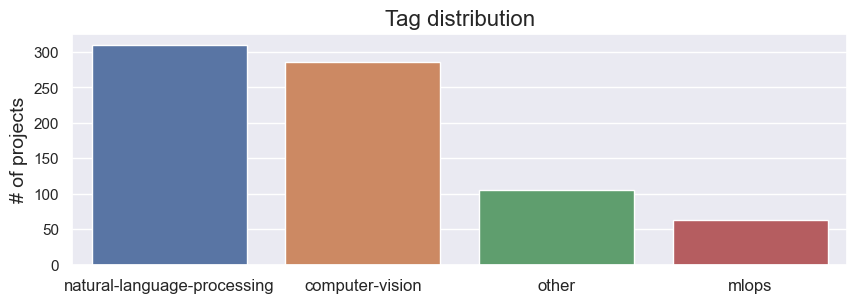

In [16]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=12)
plt.title("Tag distribution", fontsize=16)
plt.ylabel("# of projects", fontsize=14)
plt.show()

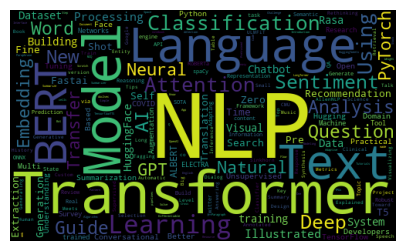

In [17]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

# Data Preprocessing

In [18]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re


# Feature engineering
df["text"] = df.title + " " + df.description

#clean text
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vipul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [20]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


In [21]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


## Label encoding

In [22]:

# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

In [23]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


In [24]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

index_to_class = {v:k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

## Tokenizer

Next we'll encode our text as well. Instead of using a random dictionary, we'll use a tokenizer that was used for a pretrained LLM (scibert) to tokenize our text. We'll be fine-tuning this exact model later when we train our model.

In [25]:
import numpy as np
from transformers import BertTokenizer

# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


In [26]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [27]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2], dtype=int64)}

In [28]:
# combining all the steps into 1 function

def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [29]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1

In [ ]:
# Apply
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1

# Distributed preprocessing
The main issue with our approach above is that we're limited by our single machine in terms how much data our dataframe can hold and that we can preprocess. With the increasing trend in ML for larger unstructured datasets and larger models (LLMs), we can quickly outgrow our single machine constraints and will need to go distributed.

In [30]:
from nlp.data import stratify_split
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [31]:
# Data ingestion
ds = ray.data.read_csv(DATASET_LOC)
ds = ds.random_shuffle(seed=1234)
ds.take(1)

# https://docs.ray.io/en/latest/data/api/input_output.html input/output link for ray

2024-07-23 13:07:52,923	INFO read_api.py:406 -- To satisfy the requested parallelism of 16, each read task output is split into 16 smaller blocks.
2024-07-23 13:07:52,962	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2024-07-23 13:07:52,967	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-07-23 13:07:52,969	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-23 13:07:52,973	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': 428,
  'created_on': datetime.datetime(2020, 4, 10, 4, 57, 53),
  'title': 'AiLight: Automatic  Highlighting Using BERT',
  'description': 'Automatically highlight pdfs using BERT embeddings and clustering.\nhttps://anishthite.github.io/ailight',
  'tag': 'natural-language-processing'}]

In [32]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

#https://docs.ray.io/en/latest/data/api/doc/ray.data.grouped_data.GroupedData.map_groups.html
# https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map_batches.html

2024-07-23 13:08:17,660	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-07-23 13:08:17,660	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-23 13:08:17,660	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
# Mapping
tags = train_ds.unique(column="tag")
class_to_index = {tag: i for i, tag in enumerate(tags)}

2024-07-23 13:08:24,936	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2024-07-23 13:08:24,939	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-23 13:08:24,941	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2024-07-23 13:08:39,675	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-07-23 13:08:39,688	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-23 13:08:39,695	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

In [34]:
# Distributed preprocessing
sample_ds = train_ds.map_batches(preprocess, fn_kwargs={"class_to_index": class_to_index}, batch_format="pandas")
sample_ds.show(1)

2024-07-23 13:08:48,539	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2024-07-23 13:08:48,540	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-23 13:08:48,542	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

(MapBatches(preprocess) pid=32356) c:\Users\Vipul\miniconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess) pid=32356)   warnings.warn(
(MapBatches(preprocess) pid=32472) c:\Users\Vipul\miniconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(MapBatches(preprocess) pid=32472)   warnings.warn(
(MapBatches(CustomPreprocessor._transform_pandas) pid=32356) c:\Users\Vipul\miniconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when

{'ids': array([ 102, 2189, 2782, 6487, 4220,  545, 3997, 1904, 5995,  103,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': 0}


# Benchmarking

We'll first set up some functions that will help us achieve complete reproducibility

In [179]:
pip install openai==0.27.8 tqdm==4.65.0 -q

Note: you may need to restart the kernel to use updated packages.


In [180]:
import openai
openai.api_key = os.getenv("OPENAI_API_KEY")

In [181]:
import pandas as pd

# Load training data
DATASET_LOC = "https://raw.githubusercontent.com/Vipulbhansali/END-TO-END-NLP-PROJECT/main/datasets/dataset.csv"
train_df = pd.read_csv(DATASET_LOC)
train_df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [182]:
# Load inference dataset
HOLDOUT_LOC = "https://raw.githubusercontent.com/Vipulbhansali/END-TO-END-NLP-PROJECT/main/datasets/holdout.csv"
test_df = pd.read_csv(HOLDOUT_LOC)

In [183]:
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.metrics import precision_recall_fscore_support
import time
from tqdm import tqdm

In [184]:
# Query OpenAI endpoint
system_content = "you only answer in rhymes"  # system content (behavior)
assistant_content = ""  # assistant content (context)
user_content = "how are you"  # user content (message)
response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": system_content},
        {"role": "assistant", "content": assistant_content},
        {"role": "user", "content": user_content},
    ],
)
print (response.to_dict()["choices"][0].to_dict()["message"]["content"])

#https://platform.openai.com/docs/quickstart

I'm here to assist, don't you fear,
Feeling great, thanks for asking, dear!


let's create a function that can predict tags for a given sample.

In [185]:
def get_tag(model, system_content="", assistant_content="", user_content=""):
    try:
        # Get response from OpenAI
        response = openai.ChatCompletion.create(
            model=model,
            messages=[
                {"role": "system", "content": system_content},
                {"role": "assistant", "content": assistant_content},
                {"role": "user", "content": user_content},
            ],
        )
        predicted_tag = response.to_dict()["choices"][0].to_dict()["message"]["content"]
        return predicted_tag

    except (openai.error.ServiceUnavailableError, openai.error.APIError) as e:
        return None

In [186]:
# Get tag
model = "gpt-3.5-turbo"
system_context = f"""
    You are a NLP prediction service that predicts the label given an input's title and description.
    You must choose between one of the following labels for each input: {tags}.
    Only respond with the label name and nothing else.
    """
assistant_content = ""
user_context = "Transfer learning with transformers: Using transformers for transfer learning on text classification tasks."
tag = get_tag(model=model, system_content=system_context, assistant_content=assistant_content, user_content=user_context)
print (tag)

natural-language-processing


In [187]:
# List of dicts w/ {title, description} (just the first 3 samples for now)
samples = test_df[["title", "description"]].to_dict(orient="records")[:3]
samples

[{'title': 'Diffusion to Vector',
  'description': 'Reference implementation of Diffusion2Vec (Complenet 2018) built on Gensim and NetworkX. '},
 {'title': 'Graph Wavelet Neural Network',
  'description': 'A PyTorch implementation of "Graph Wavelet Neural Network" (ICLR 2019) '},
 {'title': 'Capsule Graph Neural Network',
  'description': 'A PyTorch implementation of "Capsule Graph Neural Network" (ICLR 2019).'}]

In [188]:
def get_predictions(inputs, model, system_content, assistant_content=""):
    y_pred = []
    for item in tqdm(inputs):
        # Convert item dict to string
        user_content = str(item)

        # Get prediction
        predicted_tag = get_tag(
            model=model, system_content=system_content,
            assistant_content=assistant_content, user_content=user_content)

        # If error, try again after pause (repeatedly until success)
        while predicted_tag is None:
            time.sleep(30)  # could also do exponential backoff
            predicted_tag = get_tag(
                model=model, system_content=system_content,
                assistant_content=assistant_content, user_content=user_content)

        # Add to list of predictions
        y_pred.append(predicted_tag)

    return y_pred

In [158]:
# Get predictions for a list of inputs
get_predictions(inputs=samples, model=model, system_content=system_context)

100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


['natural-language-processing',
 'natural-language-processing',
 'natural-language-processing']

Next we'll define a function that can clean our predictions in the event that it's not the proper format or has hallucinated a tag outside of our expected tags.

In [189]:
def clean_predictions(y_pred, tags, default="other"):
    for i, item in enumerate(y_pred):
        if item not in tags:  # hallucinations
            y_pred[i] = default
        if item.startswith("'") and item.endswith("'"):  # GPT 4 likes to places quotes
            y_pred[i] = item[1:-1]
    return y_pred

In [190]:
def plot_tag_dist(y_true, y_pred):
    # Distribution of tags
    true_tag_freq = dict(Counter(y_true))
    pred_tag_freq = dict(Counter(y_pred))
    df_true = pd.DataFrame({"tag": list(true_tag_freq.keys()), "freq": list(true_tag_freq.values()), "source": "true"})
    df_pred = pd.DataFrame({"tag": list(pred_tag_freq.keys()), "freq": list(pred_tag_freq.values()), "source": "pred"})
    df = pd.concat([df_true, df_pred], ignore_index=True)

    # Plot
    plt.figure(figsize=(10, 3))
    plt.title("Tag distribution", fontsize=14)
    ax = sns.barplot(x="tag", y="freq", hue="source", data=df)
    ax.set_xticklabels(list(true_tag_freq.keys()), rotation=0, fontsize=8)
    plt.legend()
    plt.show()

In [191]:
def evaluate(test_df, model, system_content, assistant_content, tags):
    # Predictions
    y_test = test_df.tag.to_list()
    test_samples = test_df[["title", "description"]].to_dict(orient="records")
    y_pred = get_predictions(
        inputs=test_samples, model=model,
        system_content=system_content, assistant_content=assistant_content)
    y_pred = clean_predictions(y_pred=y_pred, tags=tags)

    # Performance
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    print(json.dumps(performance, indent=2))
    plot_tag_dist(y_true=y_test, y_pred=y_pred)
    return y_pred, performance

# Benchmarks
Now we're ready to start benchmarking our different LLMs with different context.

In [192]:
y_pred = {"zero_shot": {}, "few_shot": {}}
performance = {"zero_shot": {}, "few_shot": {}}

# Zero-shot learning
We'll start with zero-shot learning which involves providing the model with the system_content that tells it how to behave but no examples of the behavior.

In [164]:
system_content = f"""
    You are a NLP prediction service that predicts the label given an input's title and description. 
    You must choose between one of the following labels for each input: {tags}. 
    Only respond with the label name and nothing else.
    """

100%|██████████| 191/191 [02:31<00:00,  1.26it/s]


{
  "precision": 0.8211470852035387,
  "recall": 0.8429319371727748,
  "f1": 0.815312962389355
}


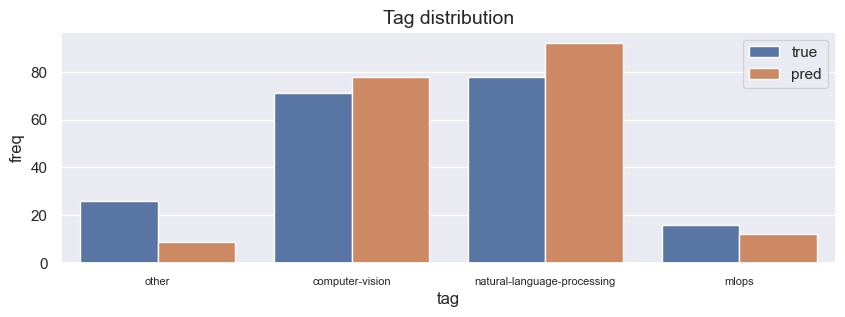

In [138]:
# Zero-shot with GPT 3.5
method = "zero_shot"
model = "gpt-3.5-turbo"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content,
    assistant_content="", tags=tags)

100%|██████████| 191/191 [03:18<00:00,  1.04s/it]


{
  "precision": 0.921179832384021,
  "recall": 0.9214659685863874,
  "f1": 0.9199061601519627
}


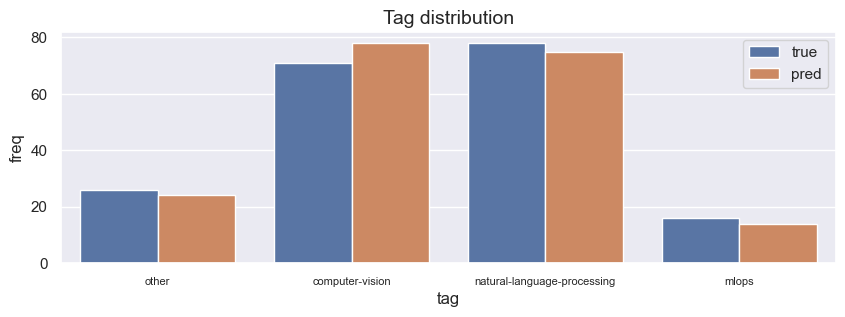

In [139]:
# Zero-shot with GPT 4
method = "zero_shot"
model = "gpt-4-0613"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content,
    assistant_content="", tags=tags)

# Few-shot learning
Now, we'll be adding a assistant_context with a few samples from our training data for each class. The intuition here is that we're giving the model a few examples (few-shot learning) of what each class looks like so that it can learn to generalize better.

In [193]:
# Create additional context with few samples from each class
num_samples = 2
additional_context = []
cols_to_keep = ["title", "description", "tag"]
for tag in tags:
    samples = train_df[cols_to_keep][train_df.tag == tag][:num_samples].to_dict(orient="records")
    additional_context.extend(samples)
additional_context

[{'title': 'Comparison between YOLO and RCNN on real world videos',
  'description': 'Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.',
  'tag': 'computer-vision'},
 {'title': 'Show, Infer & Tell: Contextual Inference for Creative Captioning',
  'description': 'The beauty of the work lies in the way it architects the fundamental idea that humans look at the overall image and then individual pieces of it.\n',
  'tag': 'computer-vision'},
 {'title': 'Pytest Board',
  'description': 'Continuous pytest runner with awesome visualization.',
  'tag': 'mlops'},
 {'title': 'Debugging Neural Networks with PyTorch and W&B',
  'description': 'A closer look at debugging common issues when training neural networks.',
  'tag': 'mlops'},
 {'title': 'Rethinking Batch Normalization in Transformers',
  'description': 'We found that NLP batch statistics exhibit large variance throughout training, which leads to poor BN performance.',
  'tag': 'na

In [194]:
# Add additional context
assistant_content = f"""Here are some examples with the correct labels: {additional_context}"""
print (assistant_content)

Here are some examples with the correct labels: [{'title': 'Comparison between YOLO and RCNN on real world videos', 'description': 'Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.', 'tag': 'computer-vision'}, {'title': 'Show, Infer & Tell: Contextual Inference for Creative Captioning', 'description': 'The beauty of the work lies in the way it architects the fundamental idea that humans look at the overall image and then individual pieces of it.\n', 'tag': 'computer-vision'}, {'title': 'Pytest Board', 'description': 'Continuous pytest runner with awesome visualization.', 'tag': 'mlops'}, {'title': 'Debugging Neural Networks with PyTorch and W&B', 'description': 'A closer look at debugging common issues when training neural networks.', 'tag': 'mlops'}, {'title': 'Rethinking Batch Normalization in Transformers', 'description': 'We found that NLP batch statistics exhibit large variance throughout training, which leads to poor BN p

100%|██████████| 191/191 [02:36<00:00,  1.22it/s]


{
  "precision": 0.845818210996041,
  "recall": 0.8638743455497382,
  "f1": 0.843104651184607
}


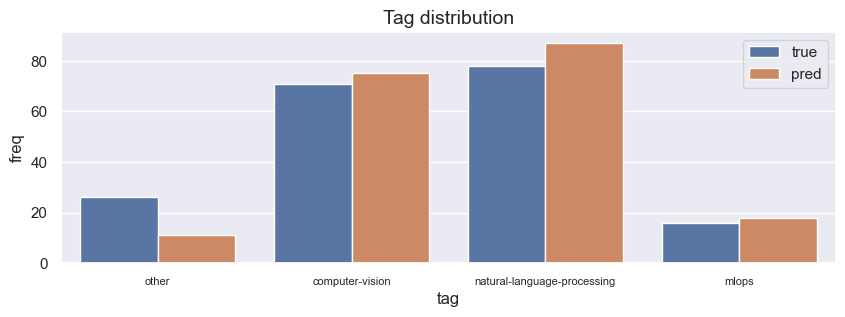

In [167]:
# Few-shot with GPT 3.5
method = "few_shot"
model = "gpt-3.5-turbo"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_df, model=model, system_content=system_content,
    assistant_content=assistant_content, tags=tags)

In [ ]:
test_subset_df = test_df.head(20)
# Few-shot with GPT-4
method = "few_shot"
model = "gpt-4-0613"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=test_subset_df, model=model, system_content=system_content,
    assistant_content=assistant_content, tags=tags)

# Set up for Training

In [36]:
import os
import random
import torch
from ray.data.preprocessor import Preprocessor

In [37]:
# setting seed

def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [38]:
def load_data(num_samples=None):
    ds = ray.data.read_csv(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

We'll also define a custom preprocessor class that we'll use to conveniently preprocess our dataset but also to save/load for later. When defining a preprocessor, we'll need to define a fit method to learn how to fit to our dataset and a _transform_{pandas|numpy} method to preprocess the dataset using any components from the _fit method.

In [65]:
class CustomPreprocessor(Preprocessor):
    """Custom preprocessor class."""
    def _fit(self, ds):
        tags = ds.unique(column="tag")
        self.class_to_index = {tag: i for i, tag in enumerate(tags)}
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}

    def _transform_pandas(self, batch):  # could also do _transform_numpy
        return preprocess(batch, class_to_index=self.class_to_index)

    def to_json(self):
        """Convert the state to a JSON-serializable dictionary."""
        return {
            "class_to_index": self.class_to_index,
            "index_to_class": self.index_to_class
        }

    @classmethod
    def from_json(cls, data):
        """Create an instance from a JSON-serializable dictionary."""
        instance = cls()
        instance.class_to_index = data["class_to_index"]
        instance.index_to_class = data["index_to_class"]
        return instance

## Model setup

In [66]:
import torch.nn as nn
from transformers import BertModel

In [67]:
# Pretrained LLM
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [68]:

import torch
# Sample
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="np", padding="longest")
batch = {k:torch.tensor(v) for k,v in batch.items()}  # convert to torch tensors
seq, pool = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
np.shape(seq), np.shape(pool)

(torch.Size([1, 10, 768]), torch.Size([1, 768]))

seq : This is the tensor containing the hidden states of the model for each token in the input sequence.The shape of seq is (batch_size, sequence_length, hidden_size), where:

- batch_size is the number of input sequences (1 in this case).
- sequence_length is the length of the input sequence after tokenization.
- hidden_size is the dimensionality of the hidden layers (number of neurons) in the BERT model in each layer.

pool (pooled output): This is the tensor representing the pooled output, usually the hidden state corresponding to the [CLS] token (the first token in the input sequence). The shape of pool is (batch_size, hidden_size)

- batch_size is the number of input sequences (1 in this case).
- hidden_size is the dimensionality of the hidden layers in the BERT model.

We're going to use this pretrained model to represent our input text features and add additional layers (linear classifier) on top of it for our specific classification task. In short, the pretrained LLM will process the tokenized text and return a sequence (one representation after each token) and pooled (combined) representation of the text. We'll use the pooled representation as input to our final fully-connection layer (fc1) to result in a vector of size num_classes (number of classes) that we can use to make predictions.

In [69]:
import torch
class FinetunedLLM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super(FinetunedLLM, self).__init__()
        self.llm = llm
        self.dropout = torch.nn.Dropout(dropout_p)
        self.fc1 = torch.nn.Linear(embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        z = self.dropout(pool)
        z = self.fc1(z)
        return z

    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(inputs)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred

    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        y_probs = F.softmax(z).cpu().numpy()
        return y_probs

In [70]:
# Initialize model
model = FinetunedLLM(llm=llm, dropout_p=0.5, embedding_dim=embedding_dim, num_classes=num_classes)
print (model.named_parameters)

<bound method Module.named_parameters of FinetunedLLM(
  (llm): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

## Batching
We can iterate through our dataset in batches however we may have batches of different sizes. Recall that our tokenizer padded the inputs to the longest item in the batch (padding="longest"). However, our batches for training will be smaller than our large data processing batches and so our batches here may have inputs with different lengths. To address this, we're going to define a custom collate_fn to repad the items in our training batches.

In [71]:
from ray.train.torch import get_device

In [72]:
# pad_array function will take an array of arrays and pad the inner arrays to the longest length.

def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][:len(row)] = row
    return padded_arr

In [73]:
#collate_fn will take a batch of data to pad them and convert them to the appropriate PyTorch tensor types.
def collate_fn(batch):
    batch["ids"] = pad_array(batch["ids"])
    batch["masks"] = pad_array(batch["masks"])
    dtypes = {"ids": torch.int32, "masks": torch.int32, "targets": torch.int64}
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(array, dtype=dtypes[key], device=get_device())
    return tensor_batch

In [74]:
# Sample batch
sample_batch = sample_ds.take_batch(batch_size=128)
collate_fn(batch=sample_batch)

2024-07-23 13:33:41,488	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=128]
2024-07-23 13:33:41,488	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-23 13:33:41,496	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

{'ids': tensor([[  102, 13568, 11404,  ...,     0,     0,     0],
         [  102,  3997,  1904,  ...,     0,     0,     0],
         [  102,  5800,  3824,  ...,     0,     0,     0],
         ...,
         [  102,  3241,  1113,  ...,     0,     0,     0],
         [  102, 17444, 30107,  ...,     0,     0,     0],
         [  102,  5590,   123,  ...,     0,     0,     0]], dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32),
 'targets': tensor([0, 1, 2, 0, 0, 2, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 1, 3, 0, 2,
         0, 1, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 0, 3, 2, 0, 1, 2, 0, 0, 2, 3,
         0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 1, 3, 0, 2, 0, 1, 3, 2, 2, 2, 2,
         3, 2, 2, 2, 2, 1, 2, 0, 3, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 3, 2, 0, 3,
         3, 0, 

## Utilities 

For Distributed Training.

In [75]:
from ray.air import Checkpoint, session
from ray.air.config import CheckpointConfig, DatasetConfig, RunConfig, ScalingConfig
import ray.train as train
from ray.train.torch import TorchCheckpoint, TorchTrainer
import torch.nn.functional as F

In [76]:
# what 1 step of training will look like

def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    """Train step."""
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()  # reset gradients
        z = model(batch)  # forward pass
        targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
        J = loss_fn(z, targets)  # define loss
        J.backward()  # backward pass
        optimizer.step()  # update weights
        loss += (J.detach().item() - loss) / (i + 1)  # cumulative loss
    return loss

In [77]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    """Eval step."""
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"], num_classes=num_classes).float()  # one-hot (for loss_fn)
            J = loss_fn(z, targets).item()
            loss += (J - loss) / (i + 1)
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(torch.argmax(z, dim=1).cpu().numpy())
    return loss, np.vstack(y_trues), np.vstack(y_preds)

Next, we'll define the train_loop_per_worker which defines the overall training loop for each worker. It's important that we include operations like loading the datasets, models, etc. so that each worker will have its own copy of these objects. Ray takes care of combining all the workers' results at the end of each iteration, so from the user's perspective, it's the exact same as training on a single machine!

The only additional lines of code we need to add compared to a typical PyTorch training loop are the following:

- session.get_dataset_shard("train") and session.get_dataset_shard("val") to load the data splits (session.get_dataset_shard).

- model = train.torch.prepare_model(model) to prepare the torch model for distributed execution (train.torch.prepare_model).

- batch_size_per_worker = batch_size // session.get_world_size() to adjust the batch size for each worker (session.get_world_size).

- session.report(metrics, checkpoint=checkpoint) to report metrics and save our model checkpoint (session.report).

All the other lines of code are the same as a typical PyTorch training loop!

In [78]:
# Training loop
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = session.get_dataset_shard("train")
    val_ds = session.get_dataset_shard("val")

    # Model
    llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FinetunedLLM(llm=llm, dropout_p=dropout_p, embedding_dim=llm.config.hidden_size, num_classes=num_classes)
    model = train.torch.prepare_model(model)

    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=lr_factor, patience=lr_patience)

    # Training
    batch_size_per_worker = batch_size // session.get_world_size()
    for epoch in range(num_epochs):
        # Step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, _, _ = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)

        # Checkpoint
        metrics = dict(epoch=epoch, lr=optimizer.param_groups[0]["lr"], train_loss=train_loss, val_loss=val_loss)
        checkpoint = TorchCheckpoint.from_model(model=model)
        session.report(metrics, checkpoint=checkpoint)

# Configurations
Next, we'll define some configurations that will be used to train our model.

In [90]:
# Train loop config
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 5,
    "batch_size": 256,
    "num_classes": num_classes,
}

Next we'll define our scaling configuration (ScalingConfig) that will specify how we want to scale our training workload. We specify the number of workers (num_workers), whether to use GPU or not (use_gpu), the resources per worker (resources_per_worker) and how much CPU each worker is allowed to use (_max_cpu_fraction_per_node).

In [80]:
# Scaling config
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker,
    
)

Next, we'll define our CheckpointConfig which will specify how we want to checkpoint our model. Here we will just save one checkpoint (num_to_keep) based on the checkpoint with the min val_loss. We'll also configure a RunConfig which will specify the name of our run and where we want to save our checkpoints.

CheckpointConfig is used to configure how checkpoints are managed during training.

Parameters:
- num_to_keep: Specifies the number of checkpoints to keep. Older checkpoints will be deleted when new ones are created, based on the checkpoint_score_attribute.

- checkpoint_score_attribute: The attribute used to score the checkpoints. Typically, this would be a metric like validation loss or accuracy.

- checkpoint_score_order: Specifies the order in which to keep the checkpoints. min indicates that lower values of the checkpoint_score_attribute are better (e.g., for loss), and max would be used if higher values are better (e.g., for accuracy).

RunConfig:
RunConfig is used to configure the overall settings for the experiment run.

Parameters:
- name: The name of the experiment run.
- checkpoint_config: An instance of CheckpointConfig that specifies how to handle checkpoints.
- local_dir: The local directory where results, including checkpoints, will be stored.

In [81]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm", checkpoint_config=checkpoint_config, local_dir="~/ray_results")

# Training

In [82]:
# Load and split data
ds = load_data()
train_ds, val_ds = stratify_split(ds, stratify="tag", test_size=test_size)

2024-07-23 13:33:51,061	INFO read_api.py:406 -- To satisfy the requested parallelism of 16, each read task output is split into 16 smaller blocks.
2024-07-23 13:33:51,085	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-07-23 13:33:51,086	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-23 13:33:51,086	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [83]:
# Preprocess
preprocessor = CustomPreprocessor()
train_ds =  preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2024-07-23 13:33:52,936	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> LimitOperator[limit=1]
2024-07-23 13:33:52,939	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-23 13:33:52,941	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2024-07-23 13:33:55,412	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> AllToAllOperator[Aggregate] -> TaskPoolMapOperator[MapBatches(<lambda>)]
2024-07-23 13:33:55,419	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-23 13:33:55,421	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

- Aggregate 11:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 12:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 13:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2024-07-23 13:33:59,375	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2024-07-23 13:33:59,375	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-23 13:33:59,385	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

2024-07-23 13:34:04,418	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV->SplitBlocks(16)] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(CustomPreprocessor._transform_pandas)]
2024-07-23 13:34:04,418	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-07-23 13:34:04,425	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- RandomShuffle 1:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/256 [00:00<?, ?it/s]

- Sort 4:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 5:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 6:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 7:   0%|          | 0/256 [00:00<?, ?it/s]

- MapBatches(group_fn)->MapBatches(_filter_split)->RandomShuffle 8:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Map 9:   0%|          | 0/256 [00:00<?, ?it/s]

Shuffle Reduce 10:   0%|          | 0/256 [00:00<?, ?it/s]

Running 0:   0%|          | 0/256 [00:00<?, ?it/s]

Sort Sample 0:   0%|          | 0/16 [00:00<?, ?it/s]

Because we've preprocessed the data prior to training, we can use the fit=False and transform=False flags in our dataset config. This will allow us to skip the preprocessing step during training.

In [84]:
# Dataset config
dataset_config = {
    "train": DatasetConfig(fit=False, transform=False, randomize_block_order=False),
    "val": DatasetConfig(fit=False, transform=False, randomize_block_order=False),
}

In [93]:
# Prepare JSON-serializable metadata
metadata = preprocessor.to_json()


# Initialize the Trainer without the preprocessor argument
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
    metadata=metadata,  # Pass metadata if necessary
)

2024-07-23 13:58:06,097	WARNING data_parallel_trainer.py:283 -- The dict form of `dataset_config` is deprecated. Use the DataConfig class instead. Support for this will be dropped in a future release.


In [ ]:
# Train
results = trainer.fit()

# Evaluation

Now that we've trained our model, we can evaluate it on a separate holdout test set.

In [ ]:
from ray.train.torch import TorchPredictor
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
class TorchPredictor:
    def __init__(self, preprocessor, model):
        self.preprocessor = preprocessor
        self.model = model
        self.model.eval()
        
    def __call__(self, batch):
        results = self.model.predict(collate_fn(batch))
        return {"output": results}

    def predict_proba(self, batch):
        results = self.model.predict_proba(collate_fn(batch))
        return {"output": results}
        
    def get_preprocessor(self):
        return self.preprocessor
        
    @classmethod
    def from_checkpoint(cls, checkpoint):
        metadata = checkpoint.get_metadata()
        preprocessor = CustomPreprocessor(class_to_index=metadata["class_to_index"])
        model = FinetunedLLM.load(Path(checkpoint.path, "args.json"), Path(checkpoint.path, "model.pt"))
        return cls(preprocessor=preprocessor, model=model)

In [ ]:
# Load the predictor and preprocessor from the best checkpoint

# Predictor
best_checkpoint = results.best_checkpoints[0][0] # gives path to best checkpoint
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [ ]:
# Test (holdout) dataset
HOLDOUT_LOC = "https://raw.githubusercontent.com/Vipulbhansali/END-TO-END-NLP-PROJECT/main/datasets/holdout.csv"
test_ds = ray.data.read_csv(HOLDOUT_LOC)
preprocessed_ds = preprocessor.transform(test_ds)
preprocessed_ds.take(1)

In [ ]:
# y_true
values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
y_true = np.stack([item["targets"] for item in values])
print (y_true)

In [ ]:
#Get our predicted label indices by using the predictor

# y_pred
z = predictor.predict(data=test_ds.to_pandas())["predictions"]
y_pred = np.stack(z).argmax(1)
print (y_pred)

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
{"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

In [ ]:
def evaluate(ds, predictor):
    # y_true
    preprocessor = predictor.get_preprocessor()
    preprocessed_ds = preprocessor.transform(ds)
    values = preprocessed_ds.select_columns(cols=["targets"]).take_all()
    y_true = np.stack([item["targets"] for item in values])
    
    # y_pred
    predictions = preprocessed_ds.map_batches(predictor).take_all()
    y_pred = np.array([d["output"] for d in predictions])

    # Evaluate
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    return performance

In [ ]:
# Evaluate on test split
performance = evaluate(ds=test_ds, predictor=predictor)
print (json.dumps(performance, indent=2))

# Inference
Now let's load our trained model for inference on new data. We'll create a few utility functions to format the probabilities into a dictionary for each class and to return predictions for each item in a dataframe.

In [1]:
import pandas as pd

def format_prob(prob, index_to_class):
    d = {}
    for i, item in enumerate(prob):
        d[index_to_class[i]] = item
    return d

In [2]:
def predict_with_proba(df, predictor):
    preprocessor = predictor.get_preprocessor()
    z = predictor.predict(data=df)["predictions"]
    y_prob = torch.tensor(np.stack(z)).softmax(dim=1).numpy()
    results = []
    for i, prob in enumerate(y_prob):
        tag = decode([z[i].argmax()], preprocessor.index_to_class)[0]
        results.append({"prediction": tag, "probabilities": format_prob(prob, preprocessor.index_to_class)})
    return results

In [ ]:
# Preprocessor
predictor = TorchPredictor.from_checkpoint(best_checkpoint)
preprocessor = predictor.get_preprocessor()

In [ ]:
# Predict on sample
title = "Transfer learning with transformers"
description = "Using transformers for transfer learning on text classification tasks."
sample_df = pd.DataFrame([{"title": title, "description": description, "tag": "other"}])
predict_with_proba(df=sample_df, predictor=predictor)